In [113]:
from pathlib import Path
import pandas as pd

DATA_PATH = Path("../data/")
PICKLE_PATH = Path("../pickled_data/")

In [114]:
game_plays = pd.read_pickle(PICKLE_PATH / 'game_plays')

In [115]:
# Ensure dateTime is in datetime format
game_plays['dateTime'] = pd.to_datetime(game_plays['dateTime'])

# Filter rows where the year is 2018
game_plays2018 = game_plays[(game_plays['dateTime'].dt.year == 2018) & (game_plays['dateTime'].dt.month == 4) & (game_plays['team_id_for'] == 20)]

# Display the first few rows
print(game_plays2018.head())


              play_id     game_id  team_id_for  team_id_against        event  \
421939   2017021268_4  2017021268         20.0             54.0      Faceoff   
421941   2017021268_6  2017021268         20.0             54.0         Shot   
421943   2017021268_8  2017021268         20.0             54.0  Missed Shot   
421946  2017021268_11  2017021268         20.0             54.0         Shot   
421947  2017021268_12  2017021268         20.0             54.0          Hit   

       secondaryType     x     y  period periodType  periodTime  \
421939           NaN   0.0   0.0       1    REGULAR           0   
421941     Slap Shot -49.0 -35.0       1    REGULAR          23   
421943           NaN -81.0  -3.0       1    REGULAR          39   
421946     Slap Shot -54.0  37.0       1    REGULAR         114   
421947           NaN -97.0   8.0       1    REGULAR         124   

        periodTimeRemaining            dateTime  goals_away  goals_home  \
421939               1200.0 2018-04-08 03

In [116]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Wedge

/var/folders/dy/q_67qnv91cv62g55t_z1_gwm0000gn/T/ipykernel_47681/2741639893.py:42: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  left_goal_crease = Wedge((-89, 0), r=6, theta1=270, theta2=90, color='skyblue', alpha=0.2, edgecolor='blue', lw=2)
/var/folders/dy/q_67qnv91cv62g55t_z1_gwm0000gn/T/ipykernel_47681/2741639893.py:43: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  right_goal_crease = Wedge((89, 0), r=6, theta1=90, theta2=270, color='skyblue', alpha=0.2, edgecolor='blue', lw=2)


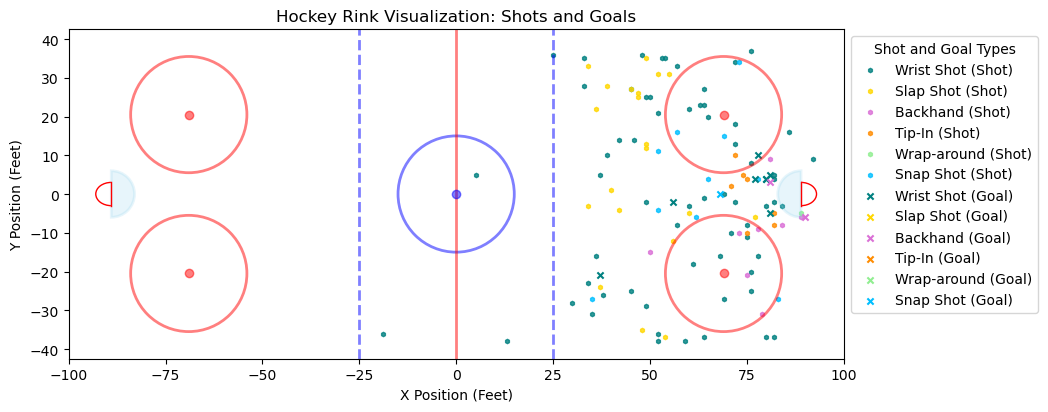

In [117]:
# Calgary Flames Shots and Goals from April 2018 (3 games)

# Function for drawing key rink features. Dimensions from https://www.hockeymanitoba.ca/wp-content/uploads/2013/03/Rink-Marking-Diagrams.pdf
def draw_rink(ax):
    '''
    Displays a hockey rink with NHL dimensions at current axes
    Parameter ax: Current axes
    Returns nothing
    '''

    # Draw the center ice line
    ax.axvline(0, color='red', linestyle='-', linewidth=2, alpha=0.5)
    
    # Draw the blue lines at +/- 25 feet from center ice
    ax.axvline(-25, color='blue', linestyle='--', linewidth=2, alpha=0.5)
    ax.axvline(25, color='blue', linestyle='--', linewidth=2, alpha=0.5)

    # Draw blue faceoff circle at center ice (15 ft radius) with blue dot at the center
    center_circle = plt.Circle((0, 0), 15, edgecolor='blue', facecolor='none', alpha = 0.5, lw=2)
    ax.add_patch(center_circle)
    ax.plot(0, 0, marker='o', color='blue', alpha = 0.5, markersize=6)  
    
    # Draw the 4 red faceoff circles with red dots at center (31 feet from end boards and 20.5 feet from side boards)
    faceoff_positions = [(69, 20.5), (-69, 20.5), (69, -20.5), (-69, -20.5)]
    for x, y in faceoff_positions:
        faceoff_circle = plt.Circle((x, y), 15, edgecolor='red', facecolor='none', alpha = 0.5, lw=2)
        ax.add_patch(faceoff_circle)
        ax.plot(x, y, marker='o', color='red', alpha = 0.5, markersize=6)  
    
    # Draw goal lines for net (6 ft)
    ax.plot([-89, -89], [-3, 3], color='red', lw=1)  # Left goal line
    ax.plot([89, 89], [-3, 3], color='red', lw=1)    # Right goal line

    # Draw back of goals as arcs (6 ft wide and 4 ft deep)
    left_goal= Arc((-89, 0), width=6, height=8, angle=90, theta1=360, theta2=180, color='red', lw=1)
    right_goal = Arc((89, 0), width=6, height=8, angle=90, theta1=180, theta2=360, color='red', lw=1)

    ax.add_patch(left_goal)
    ax.add_patch(right_goal)

    # Draw the goal creases using Wedges and fill with low opacity (6 ft radius)
    left_goal_crease = Wedge((-89, 0), r=6, theta1=270, theta2=90, color='skyblue', alpha=0.2, edgecolor='blue', lw=2)
    right_goal_crease = Wedge((89, 0), r=6, theta1=90, theta2=270, color='skyblue', alpha=0.2, edgecolor='blue', lw=2)

    ax.add_patch(left_goal_crease)
    ax.add_patch(right_goal_crease)

    # Set the rink bounds (200 ft by 85 ft)
    ax.set_xlim(-100, 100)        
    ax.set_ylim(-42.5, 42.5)

    # Treat x and y units equally so circles are drawn correctly
    ax.set_aspect('equal')

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Get the current axes
ax = plt.gca()  

# Filter shots and goals
shots = game_plays2018[game_plays2018['event'] == 'Shot']
goals = game_plays2018[game_plays2018['event'] == 'Goal']

# Give each shot a distinctive color
shot_colors = {
    'Wrist Shot': 'teal',
    'Slap Shot': 'gold',
    'Backhand': 'orchid',
    'Tip-In': 'darkorange',
    'Wrap-around': 'lightgreen',
    'Snap Shot': 'deepskyblue'
}

# Plot shots based on their type
for shot_type, color in shot_colors.items():
    show_shot = shots[(shots['secondaryType'] == shot_type)]
    ax.scatter(show_shot['st_x'], show_shot['st_y'], color=color, marker='h', s=10, label=f'{shot_type} (Shot)', alpha=0.8)

# Plot goals based on their shot type
for shot_type, color in shot_colors.items():
    show_goal = goals[goals['secondaryType'] == shot_type]
    ax.scatter(show_goal['st_x'], show_goal['st_y'], color=color, marker='x', s=20, label=f'{shot_type} (Goal)', alpha=1)

# Draw the rink at current axes using the custom function
draw_rink(ax)

# Labels and legend
plt.title("Hockey Rink Visualization: Shots and Goals")
plt.xlabel("X Position (Feet)")
plt.ylabel("Y Position (Feet)")
plt.legend(title='Shot and Goal Types', loc='upper right', bbox_to_anchor=(1.26, 1))
plt.show()

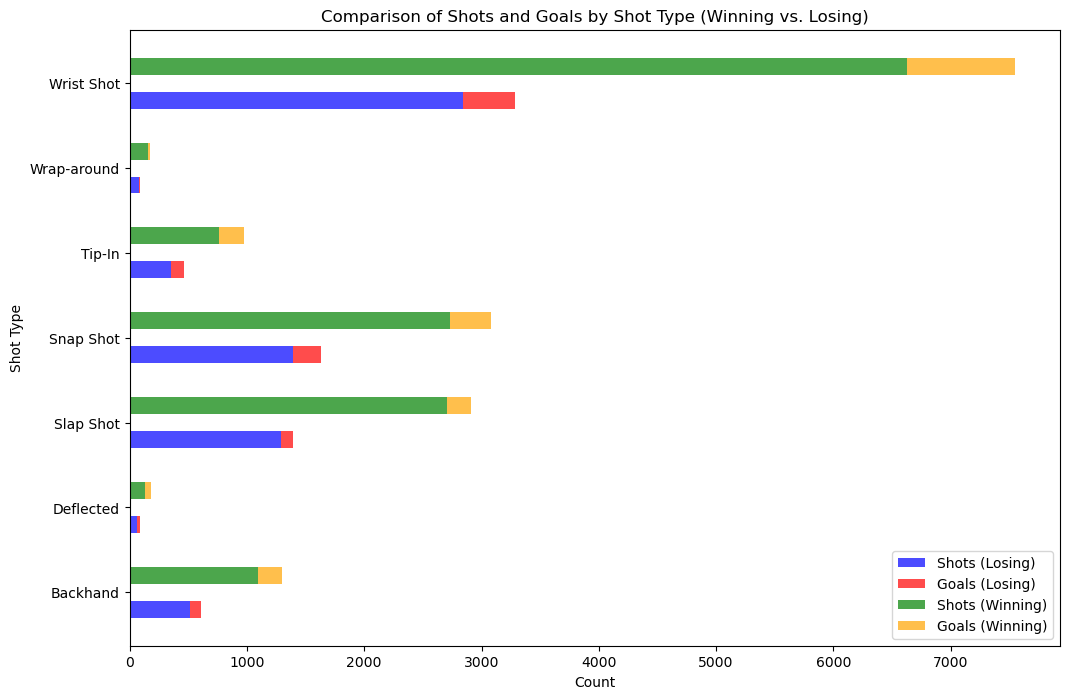

In [118]:
import matplotlib.pyplot as plt

# Visualizing shot types and goals when a team is winning and losing

# Create a column for when a team was winning
game_plays['team_winning'] = ((game_plays['team_id_for'] == game_plays['goals_home']) & (game_plays['goals_home'] > game_plays['goals_away'])) | \
                             ((game_plays['team_id_for'] == game_plays['goals_away']) & (game_plays['goals_away'] > game_plays['goals_home']))

# Create a column for when a team is losing
game_plays['team_losing'] = ((game_plays['team_id_for'] == game_plays['goals_home']) & (game_plays['goals_home'] < game_plays['goals_away'])) | \
                             ((game_plays['team_id_for'] == game_plays['goals_away']) & (game_plays['goals_away'] < game_plays['goals_home']))

# Filter shots and goals when losing
losing_shots = game_plays[(game_plays['team_losing']) & (game_plays['event'] == 'Shot')]
losing_goals = game_plays[(game_plays['team_losing']) & (game_plays['event'] == 'Goal')]

# Filter shots and goals when winning
winning_shots = game_plays[(game_plays['team_winning']) & (game_plays['event'] == 'Shot')]
winning_goals = game_plays[(game_plays['team_winning']) & (game_plays['event'] == 'Goal')]

# Count occurrences by shot type for both winning and losing scenarios
shot_types = sorted(set(losing_shots['secondaryType']).union(set(winning_shots['secondaryType'])))
losing_shot_counts = [losing_shots['secondaryType'].value_counts().get(shot_type, 0) for shot_type in shot_types]
losing_goal_counts = [losing_goals['secondaryType'].value_counts().get(shot_type, 0) for shot_type in shot_types]
winning_shot_counts = [winning_shots['secondaryType'].value_counts().get(shot_type, 0) for shot_type in shot_types]
winning_goal_counts = [winning_goals['secondaryType'].value_counts().get(shot_type, 0) for shot_type in shot_types]

# Calculate total shots and goals for percentage calculation
total_losing_shots = sum(losing_shot_counts)
total_losing_goals = sum(losing_goal_counts)
total_winning_shots = sum(winning_shot_counts)
total_winning_goals = sum(winning_goal_counts)

# Create a variable for shot types
x = range(len(shot_types))

# Set the width of the bar
bar_width = 0.2

# Set size of plot
plt.figure(figsize=(12, 8))

# Bars for losing shots and goals
losing_shot_bars = plt.barh([pos - bar_width for pos in x], losing_shot_counts, height=bar_width, color='blue', label='Shots (Losing)', alpha=0.7)
losing_goal_bars = plt.barh([pos - bar_width for pos in x], losing_goal_counts, height=bar_width, left=losing_shot_counts, color='red', label='Goals (Losing)', alpha=0.7)

# Bars for winning shots and goals
winning_shot_bars = plt.barh([pos + bar_width for pos in x], winning_shot_counts, height=bar_width, color='green', label='Shots (Winning)', alpha=0.7)
winning_goal_bars = plt.barh([pos + bar_width for pos in x], winning_goal_counts, height=bar_width, left=winning_shot_counts, color='orange', label='Goals (Winning)', alpha=0.7)

# Create labels and title
plt.ylabel('Shot Type')
plt.xlabel('Count')
plt.title('Comparison of Shots and Goals by Shot Type (Winning vs. Losing)')
plt.yticks(x, shot_types)
plt.legend()
plt.show()


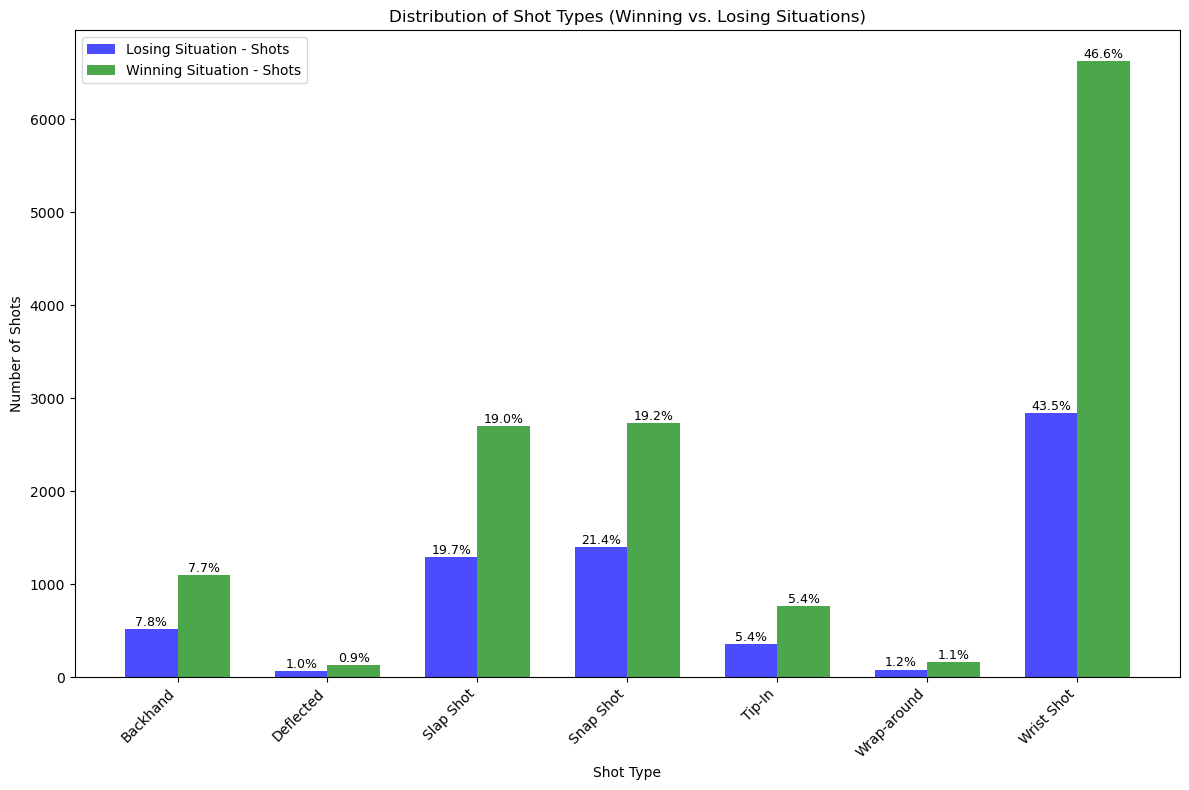

In [119]:
import numpy as np

# Create bar positions
x = np.arange(len(shot_types))
bar_width = 0.35  # Width of each bar

# Calculate percentages
losing_shot_percentages = [(count / total_losing_shots) * 100 for count in losing_shot_counts]
winning_shot_percentages = [(count / total_winning_shots) * 100 for count in winning_shot_counts]

# Set size of plot
plt.figure(figsize=(12, 8))

# Plot bars for losing and winning shots
losing_bars = plt.bar(x - bar_width/2, losing_shot_counts, bar_width, color='blue', label='Losing Situation - Shots', alpha=0.7)
winning_bars = plt.bar(x + bar_width/2, winning_shot_counts, bar_width, color='green', label='Winning Situation - Shots', alpha=0.7)

# Add percentage annotations
for i in range(len(shot_types)):
    # Losing shot percentage
    if losing_shot_counts[i] > 0:
        plt.text(x[i] - bar_width/2, losing_shot_counts[i] + 1, f"{losing_shot_percentages[i]:.1f}%", 
                 ha='center', va='bottom', fontsize=9, color='black')
    # Winning shot percentage
    if winning_shot_counts[i] > 0:
        plt.text(x[i] + bar_width/2, winning_shot_counts[i] + 1, f"{winning_shot_percentages[i]:.1f}%", 
                 ha='center', va='bottom', fontsize=9, color='black')

# Add labels and title
plt.xlabel('Shot Type')
plt.ylabel('Number of Shots')
plt.title('Distribution of Shot Types (Winning vs. Losing Situations)')
plt.xticks(x, shot_types, rotation=45, ha='right')
plt.legend()
plt.tight_layout()  
plt.show()



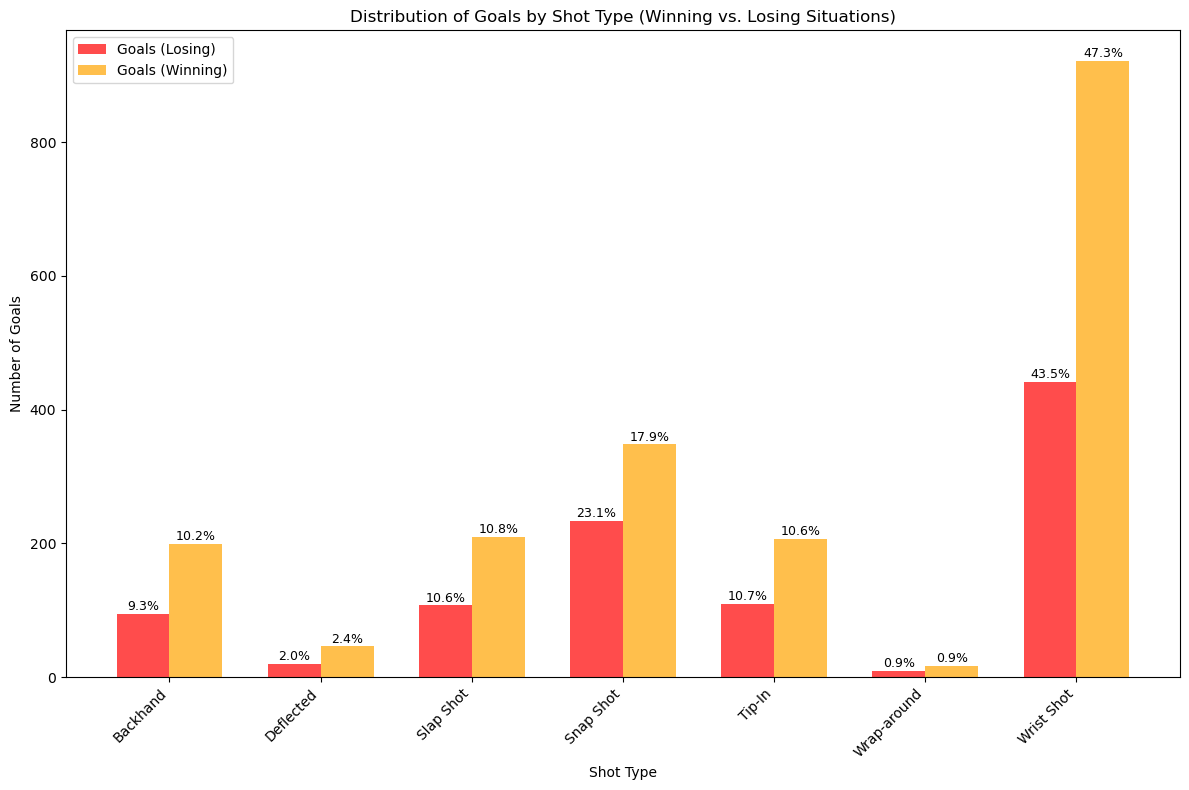

In [120]:
import matplotlib.pyplot as plt
import numpy as np

# Create bar positions
x = np.arange(len(shot_types))
bar_width = 0.35  # Width of each bar

# Calculate percentages
losing_goal_percentages = [(count / total_losing_goals) * 100 for count in losing_goal_counts]
winning_goal_percentages = [(count / total_winning_goals) * 100 for count in winning_goal_counts]

# Set size of plot
plt.figure(figsize=(12, 8))

# Plot bars for losing and winning goals
losing_goal_bars = plt.bar(x - bar_width/2, losing_goal_counts, bar_width, color='red', label='Goals (Losing)', alpha=0.7)
winning_goal_bars = plt.bar(x + bar_width/2, winning_goal_counts, bar_width, color='orange', label='Goals (Winning)', alpha=0.7)

# Add percentage annotations
for i in range(len(shot_types)):
    # Annotations for losing goals
    if losing_goal_counts[i] > 0:
        plt.text(x[i] - bar_width/2, losing_goal_counts[i] + 1, f"{losing_goal_percentages[i]:.1f}%", 
                 ha='center', va='bottom', fontsize=9, color='black')
    # Annotations for winning goals
    if winning_goal_counts[i] > 0:
        plt.text(x[i] + bar_width/2, winning_goal_counts[i] + 1, f"{winning_goal_percentages[i]:.1f}%", 
                 ha='center', va='bottom', fontsize=9, color='black')

# Add labels and title
plt.xlabel('Shot Type')
plt.ylabel('Number of Goals')
plt.title('Distribution of Goals by Shot Type (Winning vs. Losing Situations)')
plt.xticks(x, shot_types, rotation=45, ha='right')
plt.legend()
plt.tight_layout()  
plt.show()



/var/folders/dy/q_67qnv91cv62g55t_z1_gwm0000gn/T/ipykernel_47681/2741639893.py:42: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  left_goal_crease = Wedge((-89, 0), r=6, theta1=270, theta2=90, color='skyblue', alpha=0.2, edgecolor='blue', lw=2)
/var/folders/dy/q_67qnv91cv62g55t_z1_gwm0000gn/T/ipykernel_47681/2741639893.py:43: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  right_goal_crease = Wedge((89, 0), r=6, theta1=90, theta2=270, color='skyblue', alpha=0.2, edgecolor='blue', lw=2)


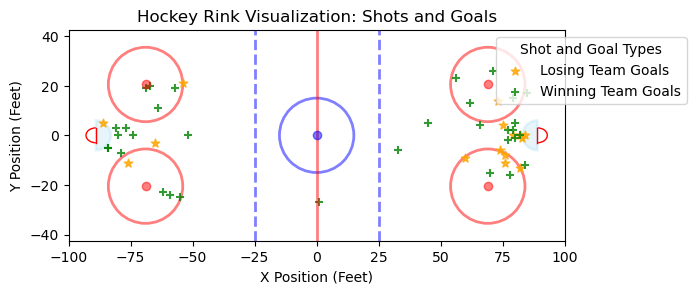

In [121]:
# Winning vs. Losing Goals October 2018
ax = plt.gca()

# Draw the rink at current axes using the custom function
draw_rink(ax)   

# Plot winning and losing team shots and goals (filtered using boolean indexing)
ax.scatter(losing_goals[(losing_goals['dateTime'].dt.year == 2018) & (losing_goals['dateTime'].dt.month == 10)]['x'], 
           losing_goals[(losing_goals['dateTime'].dt.year == 2018) & (losing_goals['dateTime'].dt.month == 10)]['y'], 
           color='orange', marker='*', s=40, label='Losing Team Goals', alpha=0.8)

ax.scatter(winning_goals[(winning_goals['dateTime'].dt.year == 2018) & (winning_goals['dateTime'].dt.month == 10)]['x'], 
           winning_goals[(winning_goals['dateTime'].dt.year == 2018) & (winning_goals['dateTime'].dt.month == 10)]['y'], 
           color='green', marker='+', s=40, label='Winning Team Goals', alpha=0.8)

# Labels and legend
plt.title("Hockey Rink Visualization: Shots and Goals")
plt.xlabel("X Position (Feet)")
plt.ylabel("Y Position (Feet)")
plt.legend(title='Shot and Goal Types', loc='upper right', bbox_to_anchor=(1.26, 1))
plt.show()

/var/folders/dy/q_67qnv91cv62g55t_z1_gwm0000gn/T/ipykernel_47681/2741639893.py:42: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  left_goal_crease = Wedge((-89, 0), r=6, theta1=270, theta2=90, color='skyblue', alpha=0.2, edgecolor='blue', lw=2)
/var/folders/dy/q_67qnv91cv62g55t_z1_gwm0000gn/T/ipykernel_47681/2741639893.py:43: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  right_goal_crease = Wedge((89, 0), r=6, theta1=90, theta2=270, color='skyblue', alpha=0.2, edgecolor='blue', lw=2)


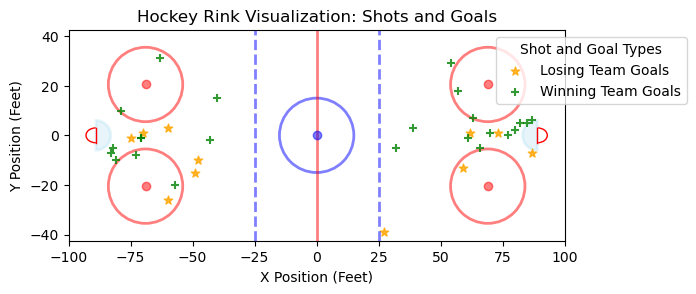

In [122]:
# Winning vs. Losing Goals April 2018
ax = plt.gca()

# Draw the rink at current axes using the custom function
draw_rink(ax)   

# Plot winning and losing team goals (filtered using boolean indexing)
ax.scatter(losing_goals[(losing_goals['dateTime'].dt.year == 2018) & (losing_goals['dateTime'].dt.month == 4)]['x'], 
           losing_goals[(losing_goals['dateTime'].dt.year == 2018) & (losing_goals['dateTime'].dt.month == 4)]['y'], 
           color='orange', marker='*', s=40, label='Losing Team Goals', alpha=0.8)

ax.scatter(winning_goals[(winning_goals['dateTime'].dt.year == 2018) & (winning_goals['dateTime'].dt.month == 4)]['x'], 
           winning_goals[(winning_goals['dateTime'].dt.year == 2018) & (winning_goals['dateTime'].dt.month == 4)]['y'], 
           color='green', marker='+', s=40, label='Winning Team Goals', alpha=0.8)

# Labels and legend
plt.title("Hockey Rink Visualization: Shots and Goals")
plt.xlabel("X Position (Feet)")
plt.ylabel("Y Position (Feet)")
plt.legend(title='Shot and Goal Types', loc='upper right', bbox_to_anchor=(1.26, 1))
plt.show()

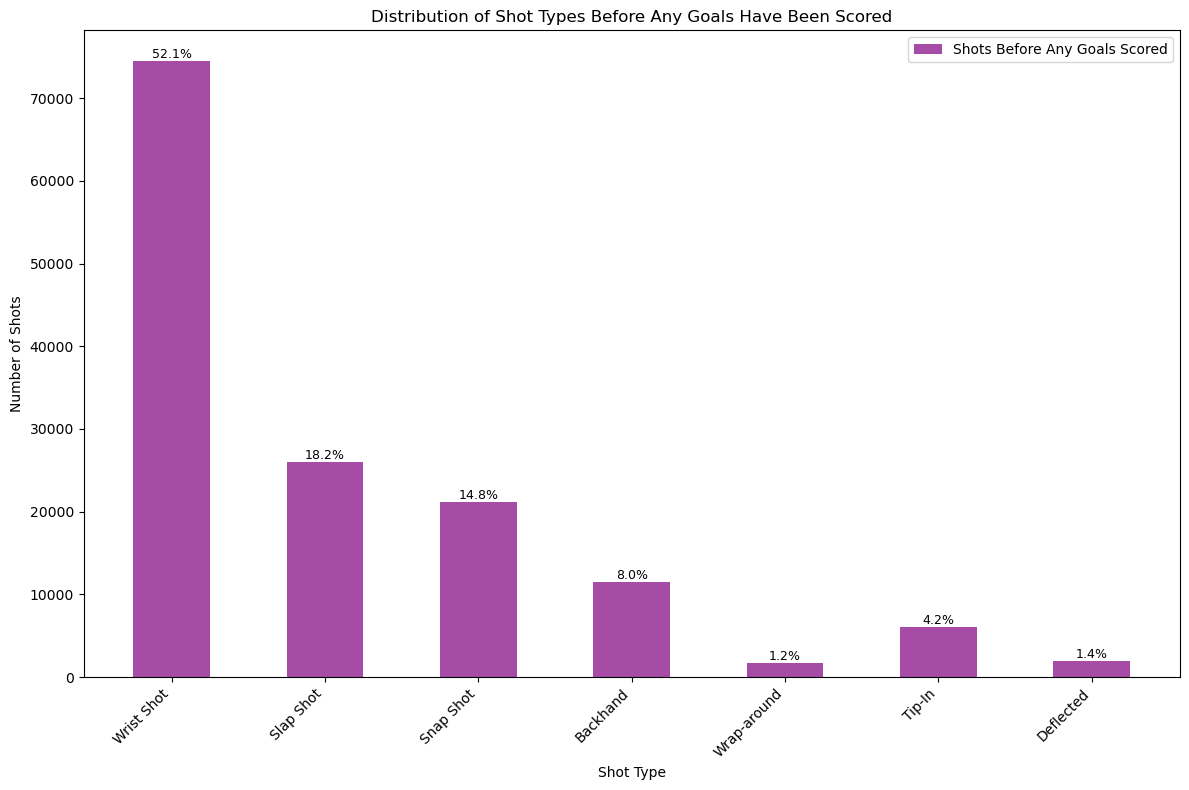

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Filter for shots before any goals have been scored
shots_no_goals_against = game_plays[
    (game_plays['event'] == 'Shot') & (game_plays['goals_home'] == 0) & (game_plays['goals_away'] == 0)
]

# Count the number of shots by type
shot_types = shots_no_goals_against['secondaryType'].unique()
shot_counts = [len(shots_no_goals_against[shots_no_goals_against['secondaryType'] == shot_type]) for shot_type in shot_types]

# Calculate total shots and percentages
total_shots = sum(shot_counts)
shot_percentages = [(count / total_shots) * 100 if total_shots > 0 else 0 for count in shot_counts]

# Create bar positions
x = np.arange(len(shot_types))
bar_width = 0.5  # Width of each bar

# Set size of plot
plt.figure(figsize=(12, 8))

# Plot bars for shot counts
bars = plt.bar(x, shot_counts, bar_width, color='orange', alpha=0.7, label='Shots Before Any Goals Scored')

# Add percentage annotations
for i in range(len(shot_types)):
    if shot_counts[i] > 0:
        plt.text(x[i], shot_counts[i] + 1, f"{shot_percentages[i]:.1f}%", 
                 ha='center', va='bottom', fontsize=9, color='black')

# Add labels and title
plt.xlabel('Shot Type')
plt.ylabel('Number of Shots')
plt.title('Distribution of Shot Types Before Any Goals Have Been Scored')
plt.xticks(x, shot_types, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


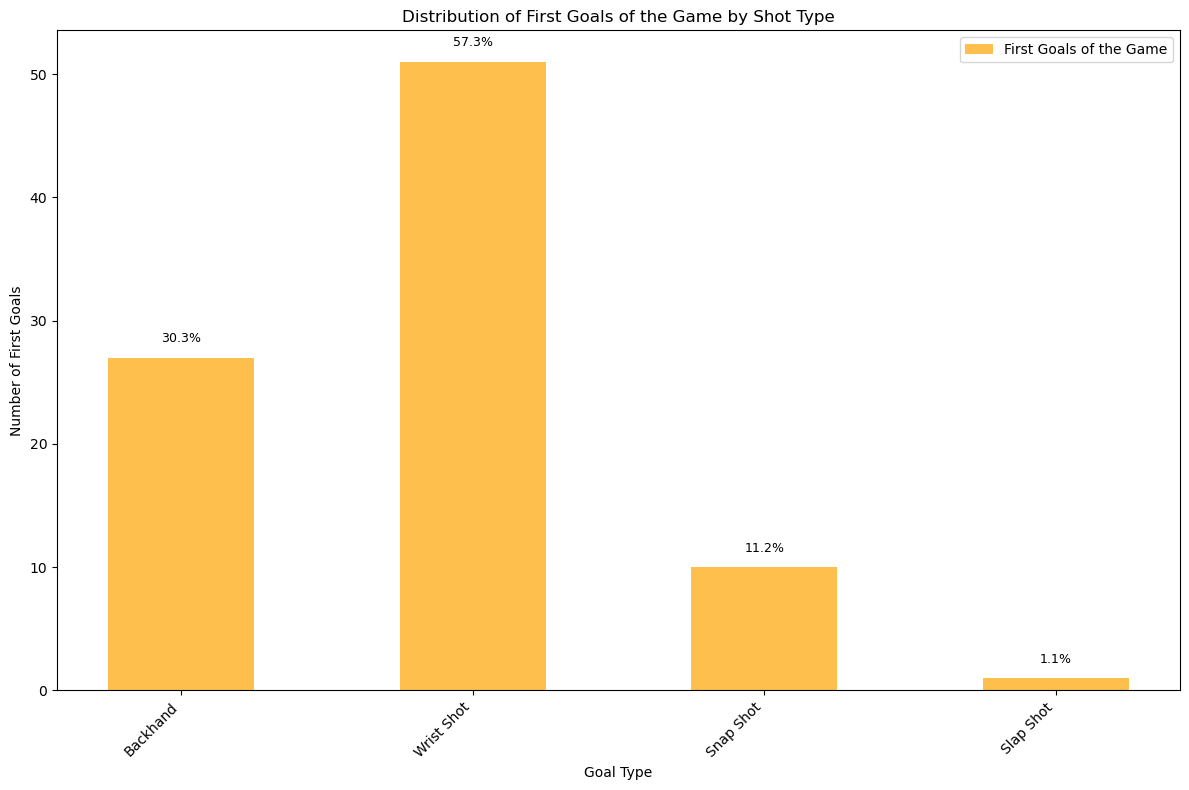

In [126]:
import numpy as np
import matplotlib.pyplot as plt

# Filter for first goals of the game (goals when no goals have been scored yet)
first_goals = game_plays[
    (game_plays['event'] == 'Goal') & (game_plays['goals_home'] == 0) & (game_plays['goals_away'] == 0)
]

# Count the number of first goals by shot type
goal_types = first_goals['secondaryType'].unique()
goal_counts = [len(first_goals[first_goals['secondaryType'] == goal_type]) for goal_type in goal_types]

# Calculate total first goals and percentages
total_goals = sum(goal_counts)
goal_percentages = [(count / total_goals) * 100 if total_goals > 0 else 0 for count in goal_counts]

# Create bar positions
x = np.arange(len(goal_types))
bar_width = 0.5  # Width of each bar

# Set size of plot
plt.figure(figsize=(12, 8))

# Plot bars for first goals
bars = plt.bar(x, goal_counts, bar_width, color='purple', alpha=0.7, label='First Goals of the Game')

# Add percentage annotations
for i in range(len(goal_types)):
    if goal_counts[i] > 0:
        plt.text(x[i], goal_counts[i] + 1, f"{goal_percentages[i]:.1f}%", 
                 ha='center', va='bottom', fontsize=9, color='black')

# Add labels and title
plt.xlabel('Goal Type')
plt.ylabel('Number of First Goals')
plt.title('Distribution of First Goals of the Game by Shot Type')
plt.xticks(x, goal_types, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/dy/q_67qnv91cv62g55t_z1_gwm0000gn/T/ipykernel_47681/2741639893.py:42: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  left_goal_crease = Wedge((-89, 0), r=6, theta1=270, theta2=90, color='skyblue', alpha=0.2, edgecolor='blue', lw=2)
/var/folders/dy/q_67qnv91cv62g55t_z1_gwm0000gn/T/ipykernel_47681/2741639893.py:43: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  right_goal_crease = Wedge((89, 0), r=6, theta1=90, theta2=270, color='skyblue', alpha=0.2, edgecolor='blue', lw=2)


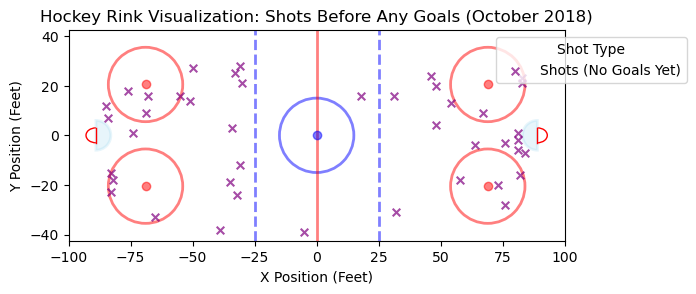

In [131]:
# Shots 

# Filter shots when goals_home == 0 and goals_away == 0 during October 2018
shots_no_goals_june_2018 = game_plays[
    (game_plays['event'] == 'Shot') &
    (game_plays['goals_home'] == 0) & 
    (game_plays['goals_away'] == 0) &
    (game_plays['dateTime'].dt.year == 2018) & 
    (game_plays['dateTime'].dt.month == 6)
]

# Set up the plot
ax = plt.gca()

# Draw the rink at current axes using the custom function
draw_rink(ax)

# Scatter plot for shots when no goals have been scored
ax.scatter(shots_no_goals_june_2018['x'], 
           shots_no_goals_june_2018['y'], 
           color='purple', marker='x', s=30, label='Shots (No Goals Yet)', alpha=0.7)

# Labels and legend
plt.title("Hockey Rink Visualization: Shots Before Any Goals (October 2018)")
plt.xlabel("X Position (Feet)")
plt.ylabel("Y Position (Feet)")
plt.legend(title='Shot Type', loc='upper right', bbox_to_anchor=(1.26, 1))
plt.show()


/var/folders/dy/q_67qnv91cv62g55t_z1_gwm0000gn/T/ipykernel_47681/2741639893.py:42: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  left_goal_crease = Wedge((-89, 0), r=6, theta1=270, theta2=90, color='skyblue', alpha=0.2, edgecolor='blue', lw=2)
/var/folders/dy/q_67qnv91cv62g55t_z1_gwm0000gn/T/ipykernel_47681/2741639893.py:43: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  right_goal_crease = Wedge((89, 0), r=6, theta1=90, theta2=270, color='skyblue', alpha=0.2, edgecolor='blue', lw=2)


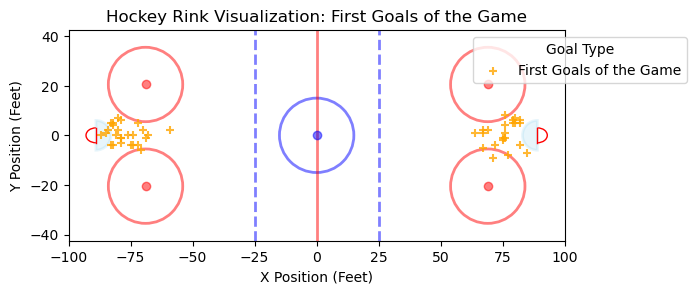

In [133]:
# Filter for goals when no goals have been scored yet
goals_no_goals_against = game_plays[
    (game_plays['event'] == 'Goal') & 
    (game_plays['goals_home'] == 0) & 
    (game_plays['goals_away'] == 0)
]

# Set up the plot
ax = plt.gca()

# Draw the rink at current axes using the custom function
draw_rink(ax)

# Scatter plot for goals when no goals have been scored
ax.scatter(goals_no_goals_against['x'], 
           goals_no_goals_against['y'], 
           color='orange', marker='+', s=40, label='First Goals of the Game', alpha=0.8)

# Labels and legend
plt.title("Hockey Rink Visualization: First Goals of the Game")
plt.xlabel("X Position (Feet)")
plt.ylabel("Y Position (Feet)")
plt.legend(title='Goal Type', loc='upper right', bbox_to_anchor=(1.26, 1))
plt.show()


In [123]:
game_penalties = pd.read_pickle(PICKLE_PATH / 'game_penalties')

merged_df = game_plays.merge(game_penalties, on='play_id', how='left')

merged_df.head()




,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,...,dateTime,goals_away,goals_home,description,st_x,st_y,team_winning,team_losing,penaltySeverity,penaltyMinutes
0,2016020045_1,2016020045,NaN,NaN,Game Scheduled,NaN,NaN,NaN,1,REGULAR,...,2016-10-18 23:40:58,0,0,Game Scheduled,NaN,NaN,False,False,NaN,NaN
1,2016020045_2,2016020045,NaN,NaN,Period Ready,NaN,NaN,NaN,1,REGULAR,...,2016-10-19 01:35:28,0,0,Period Ready,NaN,NaN,False,False,NaN,NaN
2,2016020045_3,2016020045,NaN,NaN,Period Start,NaN,NaN,NaN,1,REGULAR,...,2016-10-19 01:40:50,0,0,Period Start,NaN,NaN,False,False,NaN,NaN
3,2016020045_4,2016020045,16.0,4.0,Faceoff,NaN,0.0,0.0,1,REGULAR,...,2016-10-19 01:40:50,0,0,Jonathan Toews faceoff won against Claude Giroux,0.0,0.0,False,False,NaN,NaN
4,2016020045_5,2016020045,16.0,4.0,Shot,Wrist Shot,-71.0,9.0,1,REGULAR,...,2016-10-19 01:41:44,0,0,Artem Anisimov Wrist Shot saved by Michal Neuv...,71.0,-9.0,False,False,NaN,NaN
